<h1 style="text-align: center;">Topic Evolution in Life Sciences Research</h1>

## Proof of Concept: Modeling with the articles from _The Journal of Experimental Medicine_
The procedures below are the same as those described [here](jcb_10topics.ipynb), but performed on the collection from a different journal.

Here, I analyzed 23,246 articles from [_The Journal of Experimental Medicine_](http://jem.rupress.org/) from its inception through present (1896&ndash;2017). The corpus is made up of approximately 2.5 million words. The vocabulary was pruned and the resulting vocabulary size is 6,790. To explore the themes in the collection, I estimated a 12-component dynamic topic model. A few  of the resulting topics are illustrated in detail [below](#Process-output).

## Interpretation of Results
The 12 resulting topics can be roughly summarized as:
0. infectious disease
1. cancer
2. inflammation
3. immune response & immunization
4. organ transplants
5. development of immune cells
6. mechanism of immune response
7. serum composition
8. mixed topics
9. circulatory system
10. genetics
11. cardiovascular disease
  
A closer took at the key terms in some of these topics revealed some interesting (although maybe not so surprising) trends in research. For example, within the "infectious disease" topic, the term "pneumococcus" has been on decline since 1910s; "influenza" has remained more or less constant; 'hiv' had a sharp increase in the late 1980s but has been on a slight decline in recent years.

In [1]:
import csv
import time

import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer


# import the EDA functions I've built in a Python script
from eda import *

In [2]:
# set display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [22]:
df = pd.read_csv('/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/pmc_clean.csv', 
                 index_col='pmc')

/home/fay/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
jem = df[df.journal_title == 'The Journal of Experimental Medicine'].copy()

# customized eda function
eda(jem)

Head of the dataframe:

           article_subject  pub_year                    publisher_name  \
pmc                                                                      
5339674  Research Articles      2017  The Rockefeller University Press   
5339682  Research Articles      2017  The Rockefeller University Press   
5379968  Research Articles      2017  The Rockefeller University Press   
5379978  Research Articles      2017  The Rockefeller University Press   
5379987  Research Articles      2017  The Rockefeller University Press   

        journal_id                         journal_title  \
pmc                                                        
5339674  J Exp Med  The Journal of Experimental Medicine   
5339682  J Exp Med  The Journal of Experimental Medicine   
5379968  J Exp Med  The Journal of Experimental Medicine   
5379978  J Exp Med  The Journal of Experimental Medicine   
5379987  J Exp Med  The Journal of Experimental Medicine   

                                    

In [6]:
drop_indices = jem[(jem.article_title=='Correction') & (jem.abstract.isnull())].index
jem.drop(drop_indices, inplace=True)

drop_indices = jem[(jem.article_title=='CORRECTION') & (jem.abstract.isnull())].index
jem.drop(drop_indices, inplace=True)

drop_indices = jem[(jem.article_title=='Erratum') & (jem.abstract.isnull())].index
jem.drop(drop_indices, inplace=True)

jem.drop_duplicates(inplace=True)

# customized eda function
eda(jem)

Head of the dataframe:

           article_subject  pub_year                    publisher_name  \
pmc                                                                      
5339674  Research Articles      2017  The Rockefeller University Press   
5339682  Research Articles      2017  The Rockefeller University Press   
5379968  Research Articles      2017  The Rockefeller University Press   
5379978  Research Articles      2017  The Rockefeller University Press   
5379987  Research Articles      2017  The Rockefeller University Press   

        journal_id                         journal_title  \
pmc                                                        
5339674  J Exp Med  The Journal of Experimental Medicine   
5339682  J Exp Med  The Journal of Experimental Medicine   
5379968  J Exp Med  The Journal of Experimental Medicine   
5379978  J Exp Med  The Journal of Experimental Medicine   
5379987  J Exp Med  The Journal of Experimental Medicine   

                                    

### Prepare input files for the software

In [9]:
def prepare_dat_files(df, sorted_df_path, word2id_path, file_a_path, file_b_path):
    df = df.copy()

    # combine article title and abstract
    df['text'] = df.article_title.str.cat(df.abstract, sep=' ', na_rep=' ')
    assert df.text.isnull().sum() == 0, 'Article title/abstract cannot be null'
    print('Number of articles: {}'.format(len(df)))

    df.sort_values(by='pub_year', inplace=True)
    # save the sorted dataframe
    df.drop('text', axis=1).to_csv(sorted_df_path, chunksize=5000)
    print('Sorted csv saved at {!r}\n'.format(sorted_df_path))

    # prepare file a
    vect = vectorize(df.text, word2id_path)
    prepare_file_a(file_a_path, vect)

    # prepare file b
    prepare_file_b(file_b_path, df)


my_stopwords = {'et', 'al', 'ml'}
stopwords = set(nltk_stopwords.words('english')) | my_stopwords

def my_tokenizer(string, stopwords=stopwords):
    string = string.lower()

    tokens = re.findall(r'\b([a-z][a-z0-9]+)\b', string)

    # lemmatization
    tokens = [WordNetLemmatizer().lemmatize(token)
              for token in tokens
              if token not in stopwords]

    return tokens


def vectorize(corpus, word2id_path):
    start = time.time()
    vectorizer = CountVectorizer(tokenizer=my_tokenizer, min_df=20)
    data = vectorizer.fit_transform(corpus)

    word2id = vectorizer.vocabulary_
    print('Number of words in vocabulary: {}'.format(len(word2id)))

    # save the vocabulary and corresponding indices
    append_to_csv(word2id_path, ['word', 'index'])  # header
    for word, ind in word2id.items():
        append_to_csv(word2id_path, [word, ind])
    print('Vocabulary and corresponding indices saved at {!r}'.format(
        word2id_path))

    print('vectorize run time: {:.1f} minutes.\n'.format((time.time()-start)/60))

    return data


def prepare_file_a(file_path, sparse_csr_mat):
    start = time.time()
    index_pointers = sparse_csr_mat.indptr
    word_counts = sparse_csr_mat.data
    word_indices = sparse_csr_mat.indices

    for i in range(len(index_pointers) - 1):
        indices = word_indices[index_pointers[i]: index_pointers[i + 1]]
        counts = word_counts[index_pointers[i]: index_pointers[i + 1]]
        line = str(len(indices))
        for j, index in enumerate(indices):
            line += ' {}:{}'.format(index, counts[j])
        with open(file_path, 'a') as f:
            f.write(line + '\n')

    print('file_a saved at {!r}'.format(file_path))
    print('prepare_file_a run time: {:.1f} minutes.\n'.format(
        (time.time() - start) / 60))


def prepare_file_b(file_path, df):
    start = time.time()
    df_by_year = df.groupby('pub_year').text.agg(len)

    with open(file_path, 'a') as f:
        f.write('{}\n'.format(len(df_by_year)))
        for num_doc in df_by_year:
            f.write(str(num_doc) + '\n')

    print('file_b save at {!r}'.format(file_path))
    print('prepare_file_b run time:{:.1f} minutes.\n'.format(
        (time.time() - start) / 60))

In [10]:
!mkdir '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/'

In [11]:
sorted_df_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem_sorted.csv'
word2id_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/word2id.csv'
file_a_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem-mult.dat'
file_b_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem-seq.dat'

In [12]:
%%time
prepare_dat_files(jem, sorted_df_path, word2id_path, file_a_path, file_b_path)

Number of articles: 23246
Sorted csv saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem_sorted.csv'

Number of words in vocabulary: 6790
Vocabulary and corresponding indices saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/word2id.csv'
vectorize run time: 0.3 minutes.

file_a saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem-mult.dat'
prepare_file_a run time: 0.1 minutes.

file_b save at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem-seq.dat'
prepare_file_b run time:0.0 minutes.

CPU times: user 19.5 s, sys: 1.19 s, total: 20.7 s
Wall time: 22.6 s


### Run the software using command lines
[Skip the output of the next cell and jump to [process output](#Process-ouput)]

In [13]:
%%time
! /home/fay/code/dtm/dtm/main \
  --ntopics=12 \
  --mode=fit \
  --rng_seed=0 \
  --initialize_lda=true \
  --corpus_prefix='/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem' \
  --outname='/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run' \
  --top_chain_var=0.005 \
  --alpha=0.01 \
  --lda_sequence_min_iter=6 \
  --lda_sequence_max_iter=20 \
  --lda_max_em_iter=10

### INITIALIZING MODEL FROM LDA ###

data file: /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem
reading corpus from /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem-mult.dat
read corpus (ndocs = 23246; nterms = 6790; nwords = 2511187)

RANDOM SEED = 1504610625
e-step: processing doc 1000
e-step: processing doc 2000
e-step: processing doc 3000
e-step: processing doc 4000
e-step: processing doc 5000
e-step: processing doc 6000
e-step: processing doc 7000
e-step: processing doc 8000
e-step: processing doc 9000
e-step: processing doc 10000
e-step: processing doc 11000
e-step: processing doc 12000
e-step: processing doc 13000
e-step: processing doc 14000
e-step: processing doc 15000
e-step: processing doc 16000
e-step: processing doc 17000
e-step: processing doc 18000
e-step: processing doc 19000
e-step: processing doc 20000
e-step: processing doc 21000
e-step: processing doc 22000
e-step: processing doc 23000
initial 

e-step: processing doc 11000
e-step: processing doc 12000
e-step: processing doc 13000
e-step: processing doc 14000
e-step: processing doc 15000
e-step: processing doc 16000
e-step: processing doc 17000
e-step: processing doc 18000
e-step: processing doc 19000
e-step: processing doc 20000
e-step: processing doc 21000
e-step: processing doc 22000
e-step: processing doc 23000
iter   = 10
lhood  = -17786118.361
m, e lhood  =      0.000, -17786118.361
conv   =  3.354e-04

max_iter: 10

writing 6790 x 12 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//initial-lda.beta
writing 12 vector to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//initial-lda.alpha
writing 6790 x 12 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//initial-lda-ss.dat
fitting.. 

### FITTING DYNAMIC TOPIC MODEL ###

reading corpus from /media/fay/38E0D529E0D4EE5E/Users/Fay

(02) sslm bound = -2535605.68820; conv =  3.24670e-03

writing topic 000
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-000-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-000-var-e-log-prob.dat

writing topic 001
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run/

(02) sslm bound = -2497564.02113; conv =  7.85102e-04

writing topic 000
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-000-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-000-var-e-log-prob.dat

writing topic 001
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run/

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-000-var-e-log-prob.dat

writing topic 001
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 1


writing topic 001
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 1


writing topic 002
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 1


writing topic 003
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 1


writing topic 004
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6790 x 1


writing topic 005
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6790 x 1


writing topic 006
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6790 x 1

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 1


writing topic 008
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-e-log-prob.dat

writing topic 0

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-e-log-prob.dat

writing topic 011
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-obs.dat
writing 6790 x 1


writing topic 009
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-e-log-prob.dat

writing topic 011
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-e-log-prob.dat

(18) lda seq bo

writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-e-log-prob.dat

writing topic 011
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-e-log-prob.dat

(19) lda seq bound=-50317348.3704178; heldout bound=      0.0000000, conv=  2.1659183e-04


EM iter  20

E step

writing 23246 x 12 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Docum


writing topic 010
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-010-var-e-log-prob.dat

writing topic 011
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-obs.dat
writing 6790 x 120 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run//lda-seq/topic-011-var-e-log-prob.dat

(20) lda seq bound=-50310607.0860913; heldout bound=      0.0000000, conv=  1.3397535e-04

CPU times: user 4min 43s, sys: 37.6 s, total: 5min 20s
Wall time: 4h 53min 4s


### Process output

In [4]:
sorted_df_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/jem_sorted.csv'
word2id_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/word2id.csv'

In [5]:
jem = pd.read_csv(sorted_df_path, index_col='pmc')
jem.head(3)

,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
pmc,,,,,,,
2077823,Article,1896,The Rockefeller University Press,J Exp Med,The Journal of Experimental Medicine,OBSERVATIONS CONCERNING THE BACILLUS AEROGENES CAPSULATUS,NaN
2117911,Article,1896,The Rockefeller University Press,J Exp Med,The Journal of Experimental Medicine,ON THE ACCELERATOR AND INHIBITORY NERVES TO THE CRAB'S HEART,NaN
2077825,Article,1896,The Rockefeller University Press,J Exp Med,The Journal of Experimental Medicine,"THE VASCULAR CHANGES OF TUBERCULOUS MENINGITIS, ESPECIALLY THE TUBERCULOUS ENDARTERITIES","1. In tuberculosis meningitis there is a tuberculosis endarteritis characterized by the formation of intimal tubercles and a diffuse subendothelial, intimal proliferation due to implantation of tu..."


In [6]:
vocab = pd.read_csv(word2id_path, index_col='index').sort_index()
vocab.tail()

,word
index,
6785,zero
6786,zeta
6787,zinc
6788,zone
6789,zymosan


In [7]:
def read_topic_word_dist(topic, journal_df, output_prefix):
    word_dist_file = output_prefix + str(topic) + '-var-e-log-prob.dat'
    word_dist = np.fromfile(word_dist_file, sep='\n')
    
    # reshape the numpy array
    ncols = journal_df.pub_year.nunique()
    nrows = len(vocab)
    word_dist = np.reshape(word_dist, (nrows, ncols))
    
    # convert the numpy ndarray to pandas dataframe
    return pd.DataFrame(word_dist, 
                        columns=np.sort(journal_df.pub_year.unique()).tolist())

In [8]:
def top_words(topic_word_dist, vocab, year, num_words=10):
    indices = topic_word_dist.loc[:,year].sort_values(ascending=False).head(num_words).index
    return vocab.loc[indices, :]

In [9]:
def all_top_words(topics, journal_df, vocab, ouput_prefix):
    for topic in topics:
        word_dist = read_topic_word_dist(topic, journal_df, output_prefix)
        print('Topic {}'.format(topic))
        for year in np.sort(journal_df.pub_year.unique()):
            print("{}:\n{}\n".format(year, top_words(word_dist, vocab, year, 10).word.tolist()))
        print('-'*25)

In [10]:
output_prefix = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jem_12topics/model_run/lda-seq/topic-0'
n_topics = 12
topics = [str(i) if i > 9 else '0' + str(i) for i in range(n_topics)]

all_top_words(topics, jem, vocab, output_prefix)

Topic 00
1896:
['bacillus', 'case', 'organism', 'culture', 'pneumococcus', 'infection', 'may', 'animal', 'lesion', 'blood']

1897:
['bacillus', 'case', 'organism', 'culture', 'pneumococcus', 'infection', 'may', 'animal', 'lesion', 'blood']

1898:
['bacillus', 'case', 'organism', 'culture', 'pneumococcus', 'infection', 'may', 'animal', 'lesion', 'disease']

1899:
['bacillus', 'case', 'organism', 'culture', 'pneumococcus', 'infection', 'may', 'animal', 'lesion', 'disease']

1900:
['bacillus', 'case', 'organism', 'culture', 'pneumococcus', 'infection', 'may', 'animal', 'lesion', 'disease']

1901:
['bacillus', 'case', 'organism', 'pneumococcus', 'culture', 'infection', 'may', 'animal', 'lesion', 'disease']

1902:
['bacillus', 'case', 'organism', 'pneumococcus', 'culture', 'infection', 'animal', 'may', 'lesion', 'disease']

1905:
['bacillus', 'case', 'pneumococcus', 'organism', 'culture', 'infection', 'animal', 'lesion', 'may', 'disease']

1906:
['bacillus', 'case', 'organism', 'pneumococcu

Topic 01
1896:
['tumor', 'growth', 'mouse', 'sarcoma', 'cancer', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1897:
['tumor', 'growth', 'mouse', 'sarcoma', 'cancer', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1898:
['tumor', 'growth', 'mouse', 'sarcoma', 'cancer', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1899:
['tumor', 'growth', 'mouse', 'sarcoma', 'cancer', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1900:
['tumor', 'growth', 'mouse', 'sarcoma', 'cancer', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1901:
['tumor', 'growth', 'mouse', 'cancer', 'sarcoma', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1902:
['tumor', 'growth', 'mouse', 'cancer', 'sarcoma', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1905:
['tumor', 'growth', 'mouse', 'cancer', 'sarcoma', 'resistance', 'transplanted', 'transplantation', 'rate', 'host']

1906:
['tumor',

Topic 02
1896:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'contribution', 'inflamed', 'deficient', 'acute']

1897:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'contribution', 'inflamed', 'deficient', 'acute']

1898:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'contribution', 'inflamed', 'deficient', 'acute']

1899:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'contribution', 'inflamed', 'deficient', 'acute']

1900:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'contribution', 'inflamed', 'deficient', 'acute']

1901:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'inflamed', 'contribution', 'deficient', 'acute']

1902:
['inflammatory', 'inflammation', 'deficiency', 'joint', 'arthritis', 'peritoneal', 'inflamed', 'contribution', 'deficient', 'acute']

1905:
['inf

Topic 03
1896:
['toxin', 'serum', 'reaction', 'antitoxin', 'action', 'power', 'horse', 'diphtheria', 'test', 'substance']

1897:
['toxin', 'serum', 'reaction', 'antitoxin', 'action', 'power', 'horse', 'diphtheria', 'test', 'substance']

1898:
['toxin', 'serum', 'reaction', 'action', 'antitoxin', 'power', 'horse', 'test', 'diphtheria', 'substance']

1899:
['serum', 'toxin', 'reaction', 'action', 'antitoxin', 'horse', 'power', 'test', 'substance', 'may']

1900:
['serum', 'toxin', 'reaction', 'action', 'antitoxin', 'horse', 'power', 'test', 'substance', 'may']

1901:
['serum', 'toxin', 'reaction', 'action', 'horse', 'power', 'antitoxin', 'test', 'pneumococcus', 'may']

1902:
['serum', 'toxin', 'reaction', 'action', 'test', 'power', 'horse', 'pneumococcus', 'antitoxin', 'may']

1905:
['serum', 'toxin', 'reaction', 'action', 'test', 'power', 'horse', 'pneumococcus', 'may', 'complement']

1906:
['serum', 'reaction', 'toxin', 'action', 'test', 'complement', 'pneumococcus', 'may', 'animal', 's

Topic 04
1896:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1897:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1898:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1899:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1900:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1901:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1902:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1905:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1906:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'node', 'red', 'thymus', 'lymphoid', 'erythrocyte']

1907:
['spleen', 'lymph', 'rat', 'bone', 'marrow', 'nod

Topic 05
1896:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'granule', 'epithelial']

1897:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'granule', 'epithelial']

1898:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'granule', 'epithelial']

1899:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'granule', 'epithelial']

1900:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'epithelial', 'granule']

1901:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'small', 'large', 'human', 'epithelial', 'granule']

1902:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'large', 'small', 'human', 'epithelial', 'mononuclear']

1905:
['cell', 'blood', 'number', 'lymphocyte', 'differentiation', 'large', 'small', 'human', 'epithelial', 'mononuclear']

1906:
['cell', 'blood',

Topic 06
1896:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1897:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1898:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1899:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1900:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1901:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating', 'cytotoxic']

1902:
['stimulation', 'antigen', 'proliferative', 'stimulated', 'activity', 'sensitized', 'cell', 'proliferation', 'stimulating

Topic 07
1896:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'page', 'molecule', 'read', 'charge', 'line']

1897:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'page', 'molecule', 'read', 'charge', 'line']

1898:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'page', 'molecule', 'read', 'line', 'charge']

1899:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'page', 'molecule', 'read', 'line', 'charge']

1900:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'molecule', 'page', 'read', 'line', 'charge']

1901:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'molecule', 'page', 'read', 'line', 'charge']

1902:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'molecule', 'page', 'read', 'line', 'ph']

1905:
['protein', 'globulin', 'serum', 'albumin', 'fraction', 'molecule', 'page', 'read', 'line', 'ph']

1906:
['protein', 'globulin', 'serum', 'fraction', 'albumin', 'molecule', 'page', 'read', 'line', 'ph']

1907:
['protein', 'glo

Topic 08
1896:
['cell', 'tissue', 'giant', 'medium', 'growth', 'nucleus', 'form', 'plasma', 'culture', 'body']

1897:
['cell', 'tissue', 'giant', 'medium', 'growth', 'nucleus', 'form', 'plasma', 'culture', 'body']

1898:
['cell', 'tissue', 'giant', 'medium', 'growth', 'nucleus', 'form', 'plasma', 'culture', 'body']

1899:
['cell', 'tissue', 'giant', 'medium', 'growth', 'nucleus', 'form', 'plasma', 'culture', 'body']

1900:
['cell', 'tissue', 'giant', 'medium', 'growth', 'form', 'nucleus', 'plasma', 'culture', 'body']

1901:
['cell', 'tissue', 'medium', 'giant', 'growth', 'form', 'plasma', 'culture', 'nucleus', 'body']

1902:
['cell', 'tissue', 'medium', 'growth', 'giant', 'plasma', 'culture', 'form', 'nucleus', 'body']

1905:
['cell', 'tissue', 'medium', 'growth', 'giant', 'plasma', 'culture', 'form', 'body', 'nucleus']

1906:
['cell', 'tissue', 'medium', 'growth', 'plasma', 'culture', 'giant', 'form', 'body', 'nucleus']

1907:
['cell', 'tissue', 'medium', 'growth', 'plasma', 'culture'

Topic 09
1896:
['may', 'case', 'change', 'heart', 'one', 'result', 'tissue', 'vessel', 'found', 'blood']

1897:
['may', 'case', 'change', 'heart', 'one', 'result', 'tissue', 'found', 'blood', 'vessel']

1898:
['may', 'case', 'change', 'heart', 'one', 'result', 'tissue', 'blood', 'found', 'vessel']

1899:
['may', 'case', 'change', 'heart', 'one', 'result', 'tissue', 'blood', 'found', 'animal']

1900:
['may', 'case', 'change', 'heart', 'one', 'result', 'tissue', 'blood', 'animal', 'lesion']

1901:
['may', 'case', 'change', 'one', 'heart', 'result', 'tissue', 'blood', 'animal', 'lesion']

1902:
['may', 'case', 'change', 'one', 'result', 'heart', 'blood', 'tissue', 'lesion', 'animal']

1905:
['may', 'case', 'change', 'one', 'result', 'blood', 'heart', 'tissue', 'animal', 'lesion']

1906:
['may', 'case', 'change', 'one', 'result', 'blood', 'tissue', 'heart', 'animal', 'lesion']

1907:
['may', 'case', 'change', 'one', 'result', 'blood', 'tissue', 'animal', 'heart', 'lesion']

1908:
['may', '

Topic 10
1896:
['group', 'type', 'strain', 'two', 'difference', 'ii', 'variation', 'different', 'member', 'one']

1897:
['group', 'type', 'strain', 'two', 'difference', 'ii', 'variation', 'different', 'member', 'one']

1898:
['group', 'type', 'strain', 'two', 'ii', 'difference', 'variation', 'different', 'member', 'one']

1899:
['group', 'type', 'strain', 'two', 'ii', 'difference', 'variation', 'different', 'member', 'one']

1900:
['group', 'type', 'strain', 'two', 'ii', 'difference', 'variation', 'different', 'one', 'member']

1901:
['group', 'type', 'strain', 'two', 'ii', 'variation', 'difference', 'different', 'one', 'member']

1902:
['group', 'type', 'strain', 'two', 'ii', 'variation', 'difference', 'different', 'one', 'member']

1905:
['group', 'type', 'strain', 'two', 'ii', 'variation', 'difference', 'different', 'one', 'member']

1906:
['group', 'type', 'strain', 'two', 'ii', 'variation', 'difference', 'different', 'one', 'member']

1907:
['type', 'group', 'strain', 'two', 'ii',

Topic 11
1896:
['acid', 'fat', 'per', 'solution', 'amount', 'blood', 'cent', 'action', 'calcium', 'urine']

1897:
['acid', 'fat', 'per', 'solution', 'blood', 'amount', 'cent', 'action', 'calcium', 'urine']

1898:
['acid', 'fat', 'per', 'solution', 'blood', 'amount', 'cent', 'action', 'calcium', 'urine']

1899:
['acid', 'fat', 'per', 'solution', 'blood', 'cent', 'amount', 'action', 'calcium', 'urine']

1900:
['acid', 'fat', 'per', 'blood', 'solution', 'cent', 'amount', 'action', 'calcium', 'urine']

1901:
['acid', 'fat', 'per', 'blood', 'solution', 'cent', 'amount', 'action', 'calcium', 'urine']

1902:
['acid', 'blood', 'per', 'fat', 'solution', 'cent', 'amount', 'calcium', 'action', 'fluid']

1905:
['acid', 'blood', 'per', 'fat', 'solution', 'cent', 'calcium', 'amount', 'action', 'fluid']

1906:
['acid', 'blood', 'per', 'solution', 'fat', 'calcium', 'cent', 'fluid', 'amount', 'action']

1907:
['blood', 'acid', 'per', 'solution', 'fluid', 'cent', 'calcium', 'amount', 'fat', 'liver']

19

#### Visualization

In [11]:
def word2id(word2id_path, word):
    word2id_df = pd.read_csv(word2id_path, index_col='word')
    try:
        return word2id_df.loc[word, :].tolist()[0]
    except KeyError as e:
        print('{}; {!r} is not in the vocabulary'.format(e, word)) 

In [12]:
def plot_term_trends(topic, journal_df, word2id_path, output_prefix, terms, figsize=(12, 8)):
    topic_word_dist = read_topic_word_dist(topic, journal_df, output_prefix)

    term_indices = [word2id(word2id_path, term) for term in terms]
    colors = plt.cm.Set1(np.linspace(0,1,len(terms)))

    plot_df = topic_word_dist.loc[term_indices, :].transpose()

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    for index, term in enumerate(terms):
        ax.scatter(plot_df.index, plot_df[term_indices[index]], label='_nolabel', c=colors[index], s=30)
        ax.plot(plot_df.index, plot_df[term_indices[index]], label=term, c=colors[index])
    ax.set_title('Trends of Key Terms over Time', fontsize=22)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Log Probabilities', fontsize=18)
    ax.legend(loc='best', fontsize=14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    plt.show()

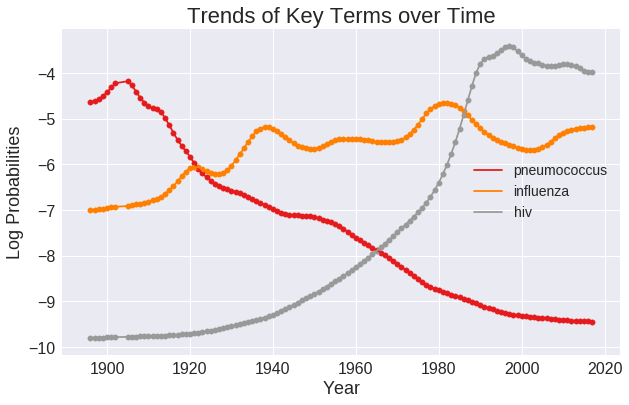

In [34]:
terms = ['pneumococcus', 'influenza', 'hiv']
plot_term_trends('00', jem, word2id_path, output_prefix, terms, figsize=(10, 6))

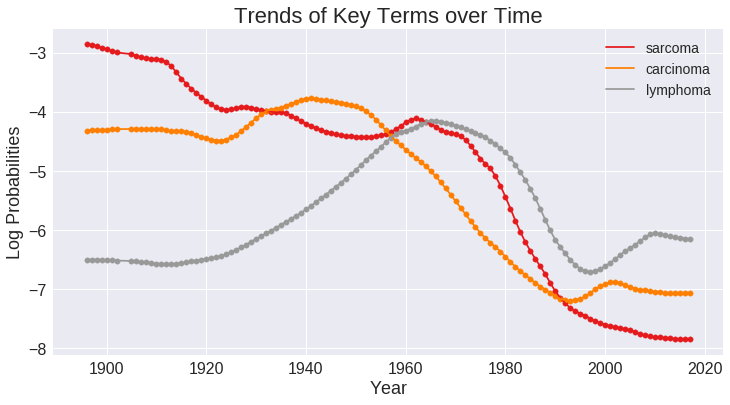

In [19]:
terms = ['sarcoma', 'carcinoma', 'lymphoma']
plot_term_trends('01', jem, word2id_path, output_prefix, terms, figsize=(12, 6))

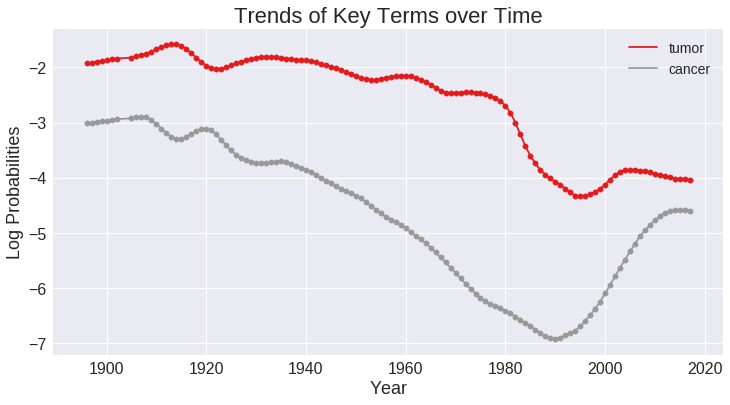

In [20]:
terms = ['tumor', 'cancer']
plot_term_trends('01', jem, word2id_path, output_prefix, terms, figsize=(12, 6))

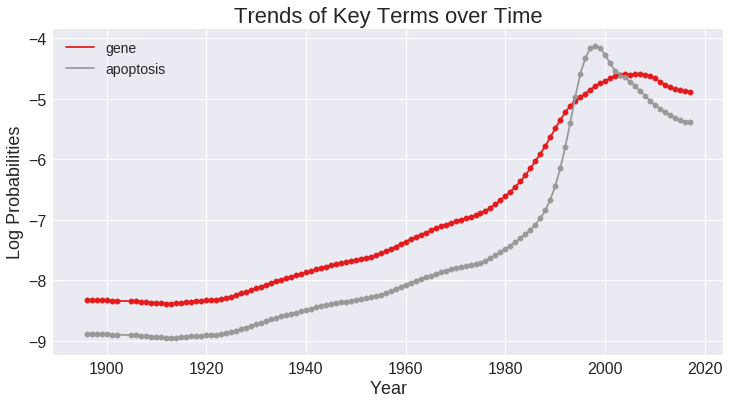

In [21]:
terms = ['gene', 'apoptosis']
plot_term_trends('01', jem, word2id_path, output_prefix, terms, figsize=(12, 6))

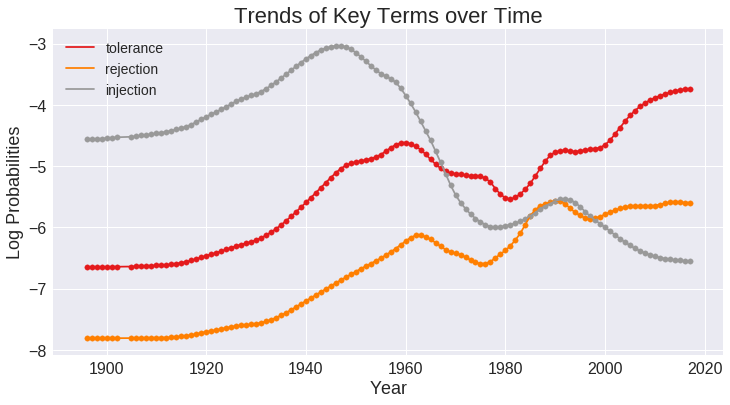

In [29]:
terms = ['tolerance', 'rejection', 'injection']
plot_term_trends('04', jem, word2id_path, output_prefix, terms, figsize=(12, 6))

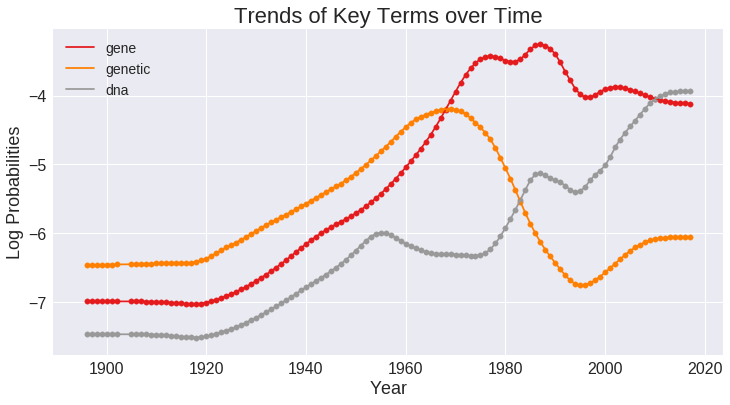

In [33]:
terms = ['gene', 'genetic', 'dna']
plot_term_trends('10', jem, word2id_path, output_prefix, terms, figsize=(12, 6))